In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

import tensorflow as tf

import yfinance as yf

2025-10-01 19:49:17.689720: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-01 19:49:17.690240: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-01 19:49:17.787163: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-01 19:49:24.378945: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

# Loading the data

Financials

In [7]:
balance_sheet = pd.read_csv('data/financials/AAPL_balance_sheet.csv')
capital_gains = pd.read_csv('data/financials/AAPL_capital_gains.csv')
cash_flow = pd.read_csv('data/financials/AAPL_cash_flow.csv')
income_statement = pd.read_csv('data/financials/AAPL_income_statement.csv')
ttm_cash_flow = pd.read_csv('data/financials/AAPL_ttm_cash_flow.csv')

Holders

In [8]:
insider_roster_holders = pd.read_csv('data/holders/AAPL_insider_roster_holders.csv')
institutional_holders = pd.read_csv('data/holders/AAPL_institutional_holders.csv')
mutualfund_holders = pd.read_csv('data/holders/AAPL_mutualfund_holders.csv')
major_holders = pd.read_csv('data/holders/AAPL_major_holders.csv')

Insider

In [9]:
insider_purchases = pd.read_csv('data/insider/AAPL_insider_purchases.csv')
insider_transactions = pd.read_csv('data/insider/AAPL_insider_transactions.csv')

Price

In [10]:
actions = pd.read_csv('data/price/AAPL_actions.csv')
dividends = pd.read_csv('data/price/AAPL_dividends.csv', index_col=0, parse_dates=True)
ohlc = pd.read_csv('data/price/AAPL_ohlc.csv', index_col=0, parse_dates=True)
options = pd.read_csv('data/price/AAPL_options.csv')
volume = pd.read_csv('data/price/AAPL_volume.csv', index_col=0, parse_dates=True)

/tmp/ipykernel_7074/3647304182.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ohlc = pd.read_csv('data/price/AAPL_ohlc.csv', index_col=0, parse_dates=True)


# Data cleaning and preprocessing

In [ ]:
total_dividend_through_years = dividends.sum()
total_number_of_stock_splits = len(splits)
# Process capital gains

Financial statement transformation

In [ ]:
final_df = pd.DataFrame(index=ohlc.index)

# Income Statement
income_stmt = data.financials.T  # Transpose so each row is a report
income_stmt.index = pd.to_datetime(income_stmt.index)  # Ensure datetime index

income_stmt_sorted = income_stmt.sort_index()
aligned_income = pd.DataFrame(index=ohlc.index, columns=income_stmt.columns)

for report_date in income_stmt_sorted.index:
    mask = (aligned_income.index >= report_date)
    aligned_income.loc[mask] = aligned_income.loc[mask].fillna(method='ffill')
    aligned_income.loc[aligned_income.index >= report_date] = \
    pd.DataFrame([income_stmt.loc[report_date].values] * len(aligned_income.loc[aligned_income.index >= report_date]),
                 index=aligned_income.loc[aligned_income.index >= report_date].index,
                 columns=aligned_income.columns)

aligned_income.fillna(method='ffill', inplace=True)

# Balance Sheet
balance_sheet = data.balance_sheet.T
balance_sheet.index = pd.to_datetime(balance_sheet.index)
balance_sheet_sorted = balance_sheet.sort_index()
aligned_balance = pd.DataFrame(index=ohlc.index, columns=balance_sheet.columns)
for report_date in balance_sheet_sorted.index:
    mask = (aligned_balance.index >= report_date)
    aligned_balance.loc[mask] = aligned_balance.loc[mask].fillna(method='ffill')
    aligned_balance.loc[aligned_balance.index >= report_date] = \
        pd.DataFrame([balance_sheet.loc[report_date].values] * len(aligned_balance.loc[aligned_balance.index >= report_date]),
                     index=aligned_balance.loc[aligned_balance.index >= report_date].index,
                     columns=aligned_balance.columns)
aligned_balance.fillna(method='ffill', inplace=True)

# Cash Flow
cashflow = data.cashflow.T
cashflow.index = pd.to_datetime(cashflow.index)
cashflow_sorted = cashflow.sort_index()
aligned_cashflow = pd.DataFrame(index=ohlc.index, columns=cashflow.columns)
for report_date in cashflow_sorted.index:
    mask = (aligned_cashflow.index >= report_date)
    aligned_cashflow.loc[mask] = aligned_cashflow.loc[mask].fillna(method='ffill')
    aligned_cashflow.loc[aligned_cashflow.index >= report_date] = \
        pd.DataFrame([cashflow.loc[report_date].values] * len(aligned_cashflow.loc[aligned_cashflow.index >= report_date]),
                     index=aligned_cashflow.loc[aligned_cashflow.index >= report_date].index,
                     columns=aligned_cashflow.columns)
aligned_cashflow.fillna(method='ffill', inplace=True)

<ipython-input-10-3143785215>:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aligned_income.loc[mask] = aligned_income.loc[mask].fillna(method='ffill')
<ipython-input-10-3143785215>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  aligned_income.loc[mask] = aligned_income.loc[mask].fillna(method='ffill')
<ipython-input-10-3143785215>:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aligned_income.loc[mask] = aligned_income.loc[mask].fillna(method='ffill')
<ipython-input-10-3143785215>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will 

In [ ]:
# Dividends
# Align dividends to ohlc index (ensure both indexes are timezone-naive)
dividends = data.dividends.copy()
dividends.index = dividends.index.tz_localize(None)
aligned_dividends = pd.DataFrame(index=ohlc.index)
aligned_dividends['Dividends'] = dividends.reindex(ohlc.index, method='ffill').fillna(0)

# Splits
# Align splits to ohlc index (ensure both indexes are timezone-naive)
splits = data.splits.copy()
splits.index = splits.index.tz_localize(None)
aligned_splits = pd.DataFrame(index=ohlc.index)
aligned_splits['Splits'] = splits.reindex(ohlc.index, method='ffill').fillna(0)

# Combine all dataframes
combined_df = pd.concat([ohlc, aligned_income, aligned_balance, aligned_cashflow, aligned_dividends, aligned_splits], axis=1)

In [ ]:
combined_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Tax Effect Of Unusual Items',
       'Tax Rate For Calcs', 'Normalized EBITDA',
       'Net Income From Continuing Operation Net Minority Interest',
       'Reconciled Depreciation',
       ...
       'Changes In Account Receivables', 'Other Non Cash Items',
       'Stock Based Compensation', 'Deferred Tax', 'Deferred Income Tax',
       'Depreciation Amortization Depletion', 'Depreciation And Amortization',
       'Net Income From Continuing Operations', 'Dividends', 'Splits'],
      dtype='object', length=167)

# EDA

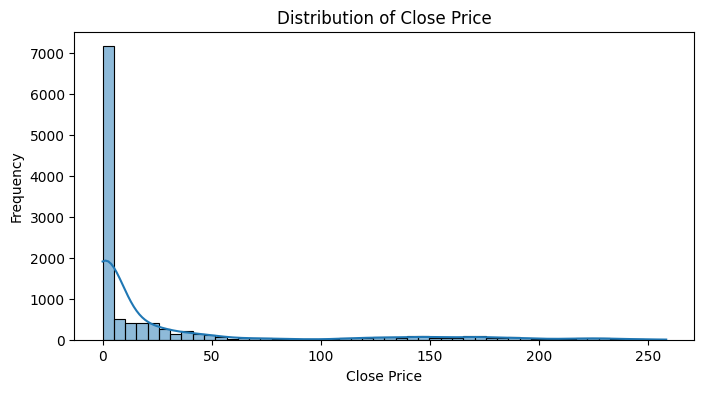

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(combined_df['Close'].dropna(), bins=50, kde=True)
plt.title('Distribution of Close Price')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()

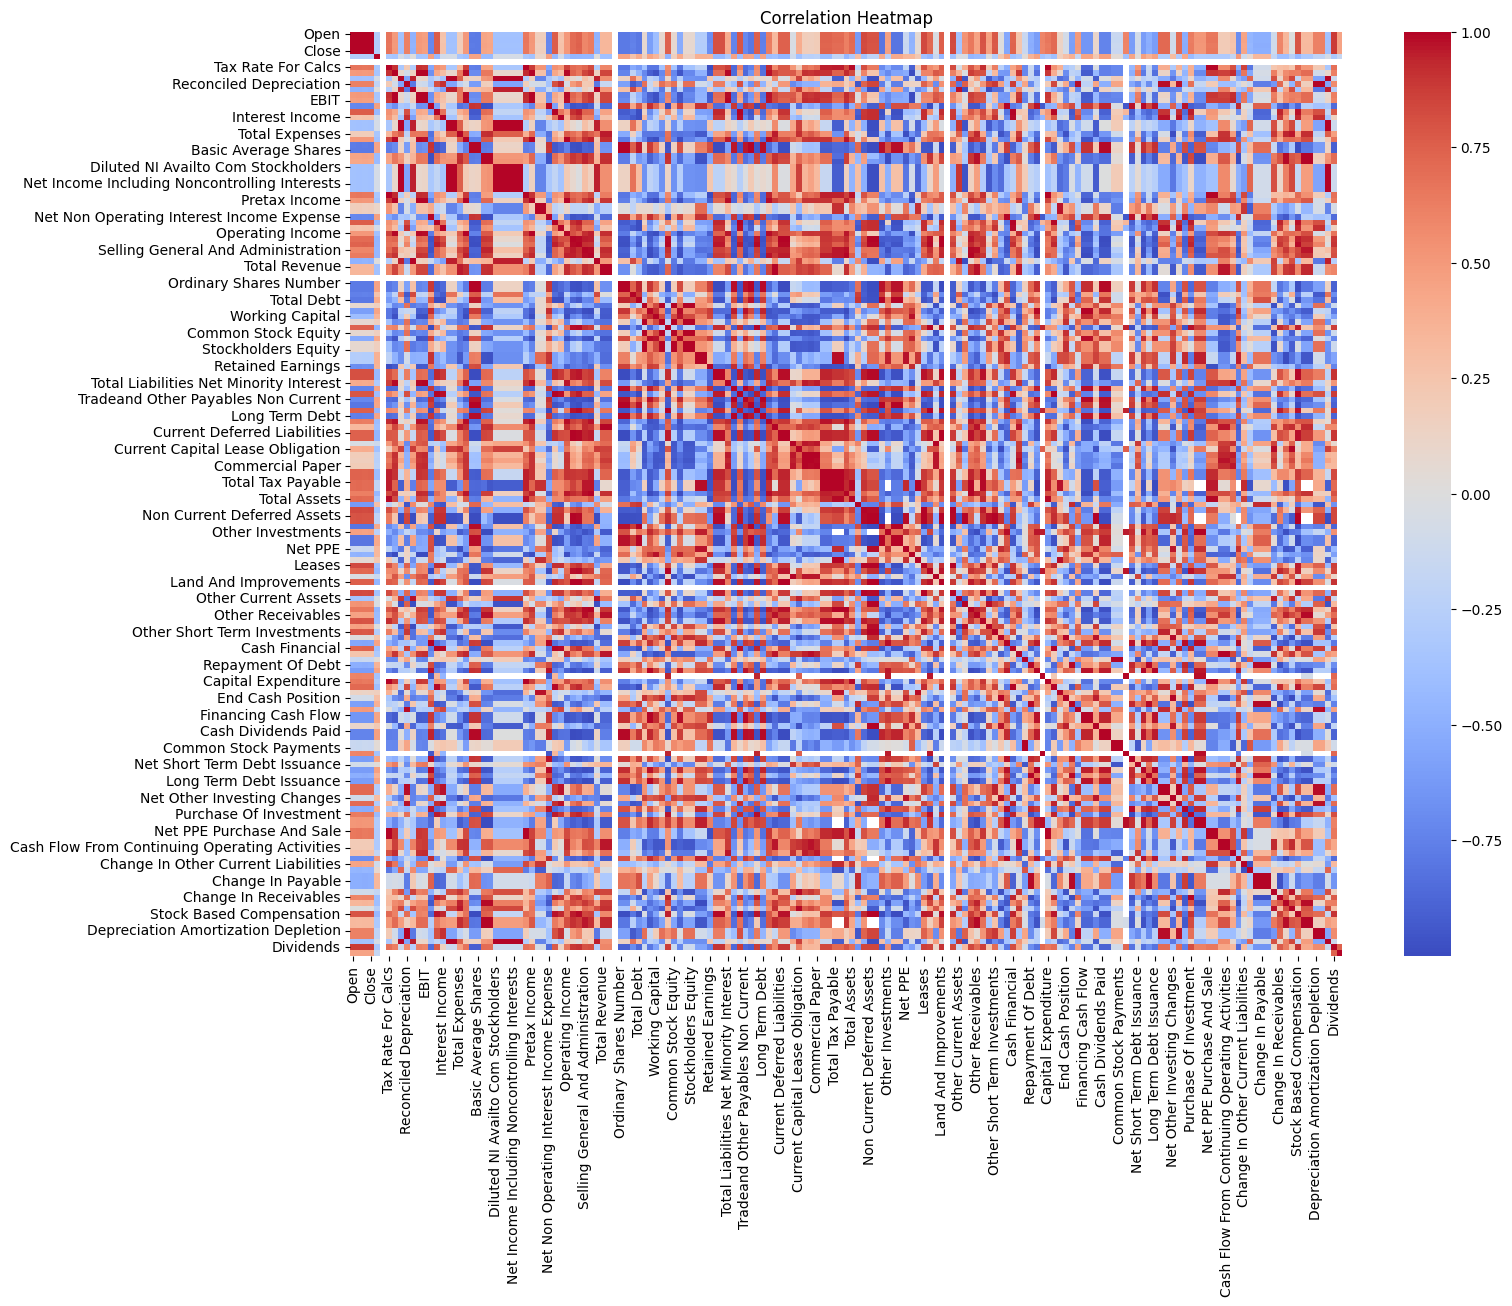

In [ ]:
plt.figure(figsize=(16, 12))
corr = combined_df.corr()
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
print(len(combined_df.columns))
print("\n")

correlations = combined_df.corr().abs()['Close'].sort_values(ascending=False)
top_correlated = correlations[1:41]
print("Top correlated variables with 'Close':")
print(top_correlated)

167


Top correlated variables with 'Close':
High                                                   0.999938
Low                                                    0.999935
Open                                                   0.999864
Dividends                                              0.876024
Leases                                                 0.831558
Other Non Current Assets                               0.830171
Current Assets                                         0.829867
Investmentin Financial Assets                          0.810259
Investments And Advances                               0.810259
Available For Sale Securities                          0.810259
Common Stock                                           0.806847
Capital Stock                                          0.806847
Long Term Debt And Capital Lease Obligation            0.802133
Accounts Receivable                                    0.796619
Total Debt                                             0.79

In [ ]:
# Calculate MACD and Signal Line
exp12 = combined_df['Close'].ewm(span=12, adjust=False).mean()
exp26 = combined_df['Close'].ewm(span=26, adjust=False).mean()
macd = exp12 - exp26
signal = macd.ewm(span=9, adjust=False).mean()

combined_df['MACD'] = macd
combined_df['MACD_Signal'] = signal

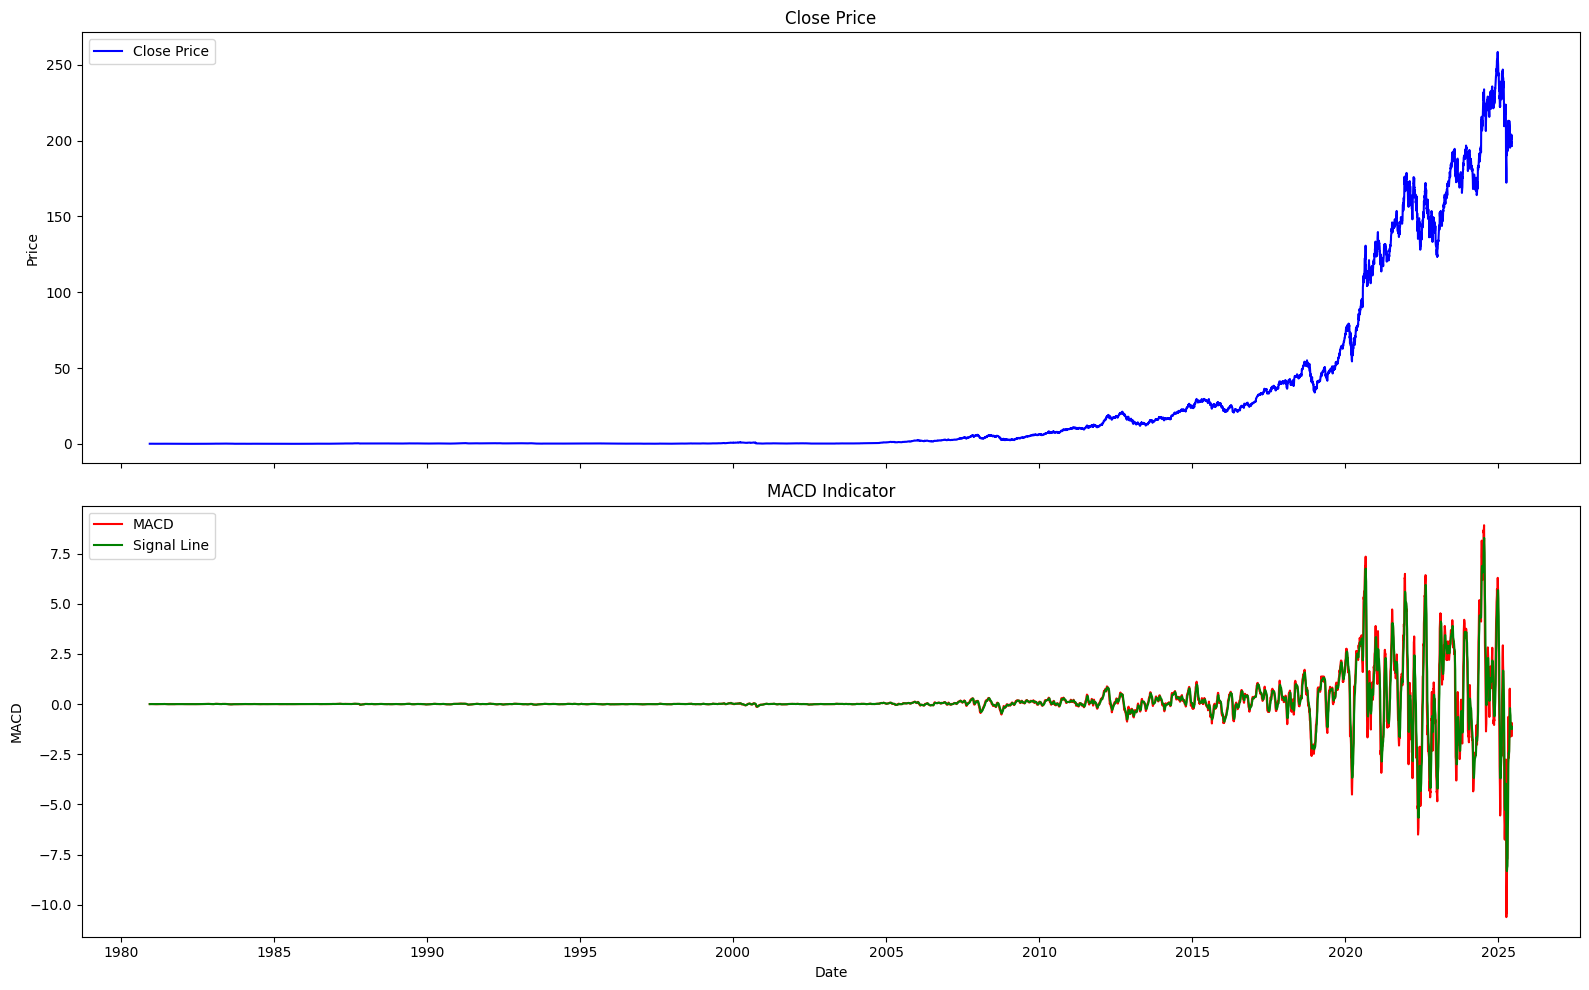

In [ ]:
# Plot Closing Price and MACD Indicator
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Plot Closing Price
ax1.plot(combined_df.index, combined_df['Close'], label='Close Price', color='blue')
ax1.set_title('Close Price')
ax1.set_ylabel('Price')
ax1.legend()

# Plot MACD and Signal Line
ax2.plot(combined_df.index, combined_df['MACD'], label='MACD', color='red')
ax2.plot(combined_df.index, combined_df['MACD_Signal'], label='Signal Line', color='green')
ax2.set_title('MACD Indicator')
ax2.set_ylabel('MACD')
ax2.set_xlabel('Date')
ax2.legend()

plt.tight_layout()
plt.show()

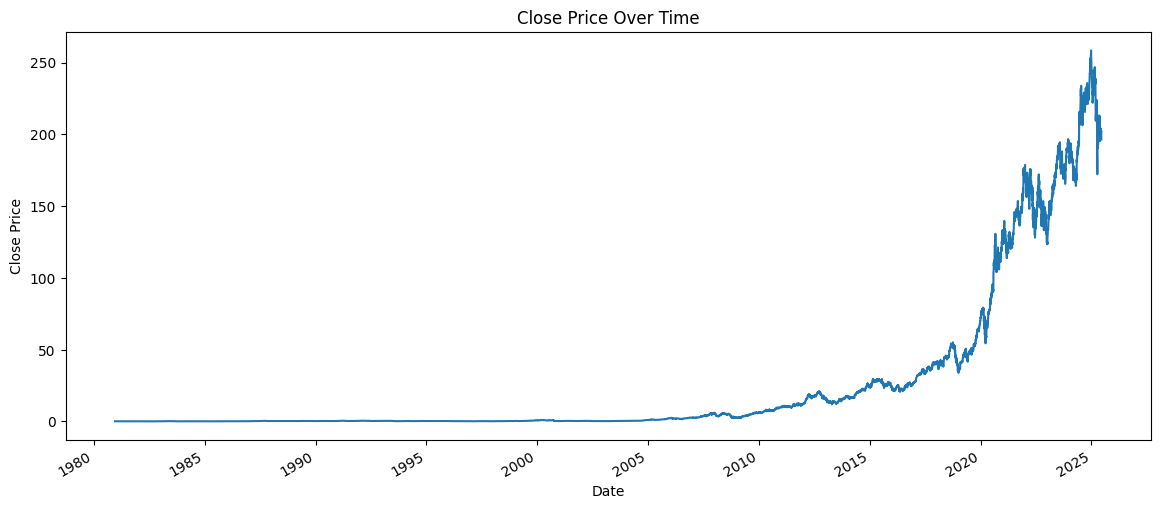

In [ ]:
plt.figure(figsize=(14, 6))
combined_df['Close'].plot()
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

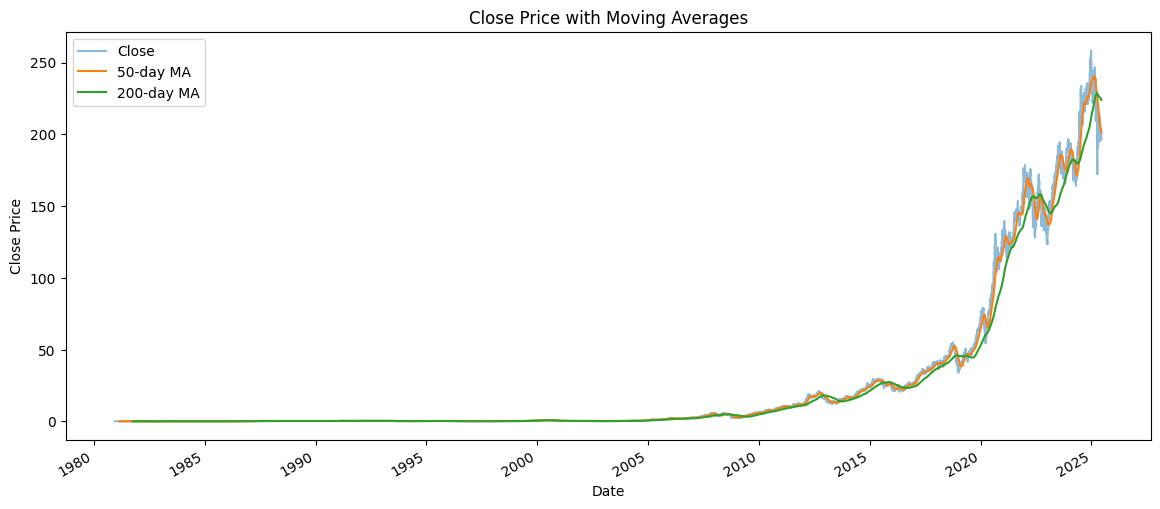

In [ ]:
plt.figure(figsize=(14, 6))
combined_df['Close'].plot(label='Close', alpha=0.5)
combined_df['Close'].rolling(window=50).mean().plot(label='50-day MA')
combined_df['Close'].rolling(window=200).mean().plot(label='200-day MA')
plt.title('Close Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

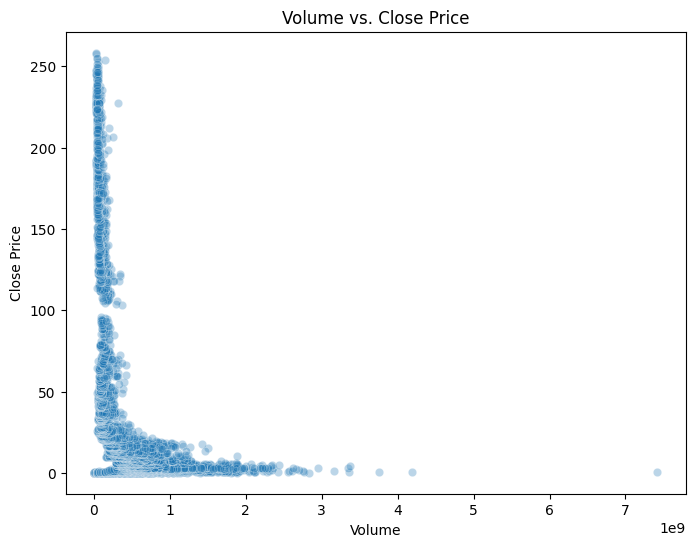

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=combined_df['Volume'], y=combined_df['Close'], alpha=0.3)
plt.title('Volume vs. Close Price')
plt.xlabel('Volume')
plt.ylabel('Close Price')
plt.show()

Add features like technical indicators

# Model creation

# Classic ML models

Linear regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

model_df = combined_df.dropna()

X = model_df.drop(columns=["Close"])
y = model_df["Close"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_regressor = LinearRegression()
lr_regressor.fit(X_train, y_train)

y_pred = lr_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression Mean Squared Error: {mse:.2f}")
print(f"Linear Regression R^2 Score: {r2:.2f}")

Linear Regression Mean Squared Error: 1.19
Linear Regression R^2 Score: 1.00


Decision tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

model_df = combined_df.dropna()

X = model_df.drop(columns=["Close"])
y = model_df["Close"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 5.07
R^2 Score: 0.99


Random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

model_df = combined_df.dropna()

X = model_df.drop(columns=["Close"])
y = model_df["Close"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

y_pred = rf_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Mean Squared Error: {mse:.2f}")
print(f"Random Forest R^2 Score: {r2:.2f}")

Random Forest Mean Squared Error: 3.22
Random Forest R^2 Score: 0.99


XGBoost

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

model_df = combined_df.dropna()

X = model_df.drop(columns=["Close"])
y = model_df["Close"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_regressor = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
xgb_regressor.fit(X_train, y_train)

y_pred = xgb_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Mean Squared Error: {mse:.2f}")
print(f"XGBoost R^2 Score: {r2:.2f}")

XGBoost Mean Squared Error: 3.64
XGBoost R^2 Score: 0.99


Support Vector Regression (SVR)

Goal: Find a function that fits the data within a margin of tolerance (ε), and is as flat as possible.



In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

model_df = combined_df.dropna()
X = model_df.drop(columns=["Close"])
y = model_df["Close"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svr_regressor = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_regressor.fit(X_train, y_train)

y_pred = svr_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"SVR Mean Squared Error: {mse:.2f}")
print(f"SVR R^2 Score: {r2:.2f}")

SVR Mean Squared Error: 527.09
SVR R^2 Score: -0.09


K-Nearest Neighbors Regression (KNN)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

model_df = combined_df.dropna()
X = model_df.drop(columns=["Close"])
y = model_df["Close"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn_regressor = KNeighborsRegressor(n_neighbors=5)
knn_regressor.fit(X_train, y_train)

y_pred = knn_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"KNN Mean Squared Error: {mse:.2f}")
print(f"KNN R^2 Score: {r2:.2f}")

KNN Mean Squared Error: 299.93
KNN R^2 Score: 0.38


LightGBM Regression

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

model_df = combined_df.dropna()
X = model_df.drop(columns=["Close"])
y = model_df["Close"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lgbm_regressor = LGBMRegressor(n_estimators=100, random_state=42)
lgbm_regressor.fit(X_train, y_train)

y_pred = lgbm_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"LightGBM Mean Squared Error: {mse:.2f}")
print(f"LightGBM R^2 Score: {r2:.2f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1101
[LightGBM] [Info] Number of data points in the train set: 341, number of used features: 145
[LightGBM] [Info] Start training from score 207.093286
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

# Deep learning

Neural Network Regression (MLP)

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

model_df = combined_df.dropna()
X = model_df.drop(columns=["Close"])
y = model_df["Close"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mlp_regressor = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
mlp_regressor.fit(X_train, y_train)

y_pred = mlp_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MLP Mean Squared Error: {mse:.2f}")
print(f"MLP R^2 Score: {r2:.2f}")

MLP Mean Squared Error: 16106838173308690.00
MLP R^2 Score: -33440534746653.64


LSTM Neural Network Regression (Keras)

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

model_df = combined_df.dropna()
X = model_df.drop(columns=["Close"])
y = model_df["Close"]

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Reshape for LSTM: (samples, timesteps, features)
# We'll use a window of 1 (no lookback)
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_scaled, test_size=0.2, random_state=42)

model = Sequential([
    LSTM(50, input_shape=(X_lstm.shape[1], X_lstm.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)

mse = mean_squared_error(y_test_inv, y_pred)
r2 = r2_score(y_test_inv, y_pred)

print(f"LSTM Mean Squared Error: {mse:.2f}")
print(f"LSTM R^2 Score: {r2:.2f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step
LSTM Mean Squared Error: 6.25
LSTM R^2 Score: 0.99


# Time-series models

ARIMA/SARIMA Time Series Forecasting

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score

# Use only the 'Close' price for time series forecasting
model_df = combined_df.dropna()
close_series = model_df['Close']

# Split into train and test sets (time series split, no shuffling)
split_idx = int(len(close_series) * 0.8)
train, test = close_series.iloc[:split_idx], close_series.iloc[split_idx:]

# Fit SARIMA model (simple order, can be tuned)
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit(disp=False)

# Forecast using integer-based index to avoid KeyError
forecast = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

mse = mean_squared_error(test, forecast)
r2 = r2_score(test, forecast)

print(f"SARIMA Mean Squared Error: {mse:.2f}")
print(f"SARIMA R^2 Score: {r2:.2f}")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA Mean Squared Error: 841.53
SARIMA R^2 Score: -1.92


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Prophet Time Series Forecasting

In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score

model_df = combined_df.dropna()
close_series = model_df['Close']

# Prophet requires a DataFrame with columns 'ds' and 'y'
df_prophet = close_series.reset_index()
df_prophet.columns = ['ds', 'y']

# Ensure 'ds' is datetime and daily frequency
if not np.issubdtype(df_prophet['ds'].dtype, np.datetime64):
    df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
df_prophet = df_prophet.sort_values('ds')
df_prophet = df_prophet.set_index('ds').asfreq('D').reset_index()

# Fill missing values (Prophet cannot handle NaN)
df_prophet['y'] = df_prophet['y'].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')

# Split into train and test sets
split_idx = int(len(df_prophet) * 0.8)
train, test = df_prophet.iloc[:split_idx], df_prophet.iloc[split_idx:]

model = Prophet()
model.fit(train)

future = model.make_future_dataframe(periods=len(test), freq='D')
forecast = model.predict(future)

# Align forecast with test set
y_pred = forecast['yhat'].iloc[-len(test):].values
mse = mean_squared_error(test['y'], y_pred)
r2 = r2_score(test['y'], y_pred)

print(f"Prophet Mean Squared Error: {mse:.2f}")
print(f"Prophet R^2 Score: {r2:.2f}")

<ipython-input-31-2303264498>:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_prophet['y'] = df_prophet['y'].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc9fjbj7i/wshgo3ix.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc9fjbj7i/n252pqfi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61264', 'data', 'file=/tmp/tmpc9fjbj7i/wshgo3ix.json', 'init=/tmp/tmpc9fjbj7i/n252pqfi.json', 'output', 'file=/tmp/tmpc9fjbj7i/prophet_modeljc9owc7s/prophet_model-20250613221057.csv', 'method=op

Prophet Mean Squared Error: 1547.06
Prophet R^2 Score: -4.19


# Ensemble learning

Ensemble Method: Averaging Predictions from Multiple Models

In [ ]:
# Example: Average predictions from Linear Regression, Random Forest, and XGBoost
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

model_df = combined_df.dropna()
X = model_df.drop(columns=["Close"])
y = model_df["Close"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train models
lr = LinearRegression().fit(X_train, y_train)
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
xgb = XGBRegressor(n_estimators=100, random_state=42, verbosity=0).fit(X_train, y_train)

# Predict
y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_xgb = xgb.predict(X_test)

# Ensemble: simple average
y_pred_ensemble = (y_pred_lr + y_pred_rf + y_pred_xgb) / 3

mse = mean_squared_error(y_test, y_pred_ensemble)
r2 = r2_score(y_test, y_pred_ensemble)

print(f"Ensemble Mean Squared Error: {mse:.2f}")
print(f"Ensemble R^2 Score: {r2:.2f}")

Ensemble Mean Squared Error: 2.19
Ensemble R^2 Score: 1.00


# New models

In [ ]:
!pip install catboost
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'combined_df' is already defined and contains your data
model_df = combined_df.dropna()

X = model_df.drop(columns=["Close"])
y = model_df["Close"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the CatBoost Regressor
# verbose=0 to suppress training output, you can remove this for more detailed output
catboost_regressor = CatBoostRegressor(iterations=100, random_state=42, verbose=0)
catboost_regressor.fit(X_train, y_train)

# Make predictions
y_pred = catboost_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"CatBoost Mean Squared Error: {mse:.2f}")
print(f"CatBoost R^2 Score: {r2:.2f}") #d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00
CatBoost Mean Squared Error: 5.87
CatBoost R^2 Score: 0.99
